In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jlinops

In [66]:
np.random.seed(0)


n_uniform = 50
x_uniform = np.linspace(0,1,n_uniform)
y_uniform = np.cumsum(np.random.normal(size=n_uniform))


n_nonuniform = 15
x_nonuniform = np.linspace(0,1,n_nonuniform) +  0.01*np.random.normal(size=n_nonuniform)
x_nonuniform = np.clip(x_nonuniform, a_min=np.amin(x_uniform), a_max=np.amax(x_uniform))


In [67]:
x_uniform

array([0.        , 0.02040816, 0.04081633, 0.06122449, 0.08163265,
       0.10204082, 0.12244898, 0.14285714, 0.16326531, 0.18367347,
       0.20408163, 0.2244898 , 0.24489796, 0.26530612, 0.28571429,
       0.30612245, 0.32653061, 0.34693878, 0.36734694, 0.3877551 ,
       0.40816327, 0.42857143, 0.44897959, 0.46938776, 0.48979592,
       0.51020408, 0.53061224, 0.55102041, 0.57142857, 0.59183673,
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ])

In [5]:
x_nonuniform

array([0.        , 0.0752976 , 0.13774909, 0.20247939, 0.28543246,
       0.36142618, 0.4292366 , 0.50302472, 0.56508535, 0.63922973,
       0.70756111, 0.78211875, 0.84901139, 0.9113086 , 1.        ])

In [ ]:
# Need a function that finds the index and straddling two x coordinates on the uniform grid
def 

In [86]:
class Uniform1DGrid:
    """Represents a uniform 1D grid.
    """

    def __init__(self, interval, n_points, y_obs):
        self.interval = interval
        self.a, self.b = interval
        self.n_points = n_points
        self.x_grid = np.linspace(self.a, self.b, self.n_points)
        self.h = self.x_grid[1] - self.x_grid[0]

        assert len(y_obs) == n_points, "length of y_obs does not match the grid parameters."
        self.y_obs = y_obs

    def nearest_grid_idx(self, x):
        """Given an array of x-coordinates, returns the index of the nearest x-cordinate 
        (from the left) on the grid.
        """
        assert np.all(np.diff(x) >= 0), "Array must be ordered in increasing order."
        assert np.amin(x) > self.a, "query points must be in between interval endpoints."
        assert np.amax(x) < self.b, "query points must be in between interval endpoints."

        indices = np.searchsorted(self.x_grid, x, side='right') - 1
        
        return indices
    

    def linear_interpolation(self, x):

        idxs = self.nearest_grid_idx(x)
        left_grid_points = self.x_grid[idxs]
        left_y_obs = self.y_obs[idxs]
        right_y_obs = self.y_obs[idxs + 1]
 
        return left_y_obs + ((x-left_grid_points)/self.h)*(right_y_obs - left_y_obs)




In [87]:
grid = Uniform1DGrid((0,1), len(x_uniform), y_uniform)

In [88]:
rand_x = np.sort(np.random.uniform(low=0.1, high=0.8, size=12))

In [89]:
grid.nearest_grid_idx(rand_x)

array([12, 15, 18, 20, 24, 28, 28, 32, 33, 35, 35, 37])

In [90]:
grid.linear_interpolation(rand_x)

array([ 9.80671462, 10.79132576, 11.81361425,  8.9882178 , 10.66108317,
       12.77705069, 13.12720712, 11.32010475, 10.62603053, 10.90855617,
       10.93523287, 12.96695352])

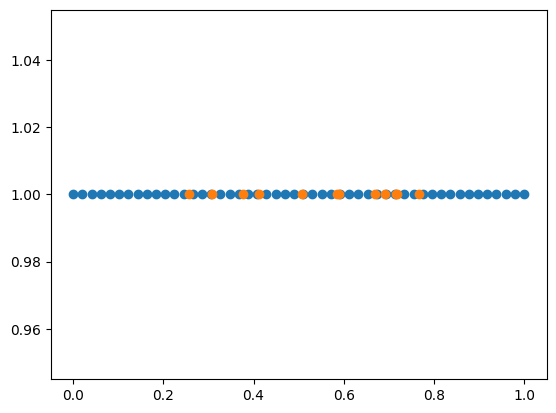

In [91]:
plt.scatter(grid.x_grid, np.ones_like(grid.x_grid))
plt.scatter(rand_x, np.ones_like(rand_x))
plt.show()

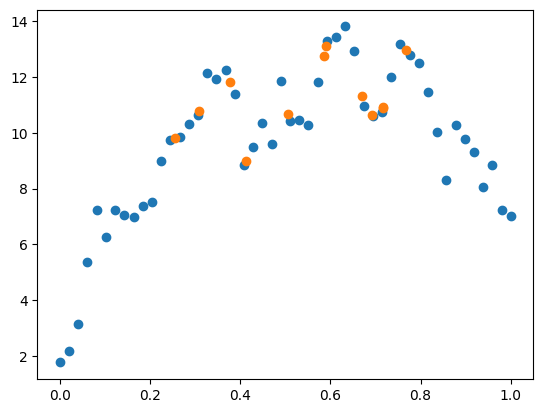

In [92]:
plt.scatter(grid.x_grid, grid.y_obs)
plt.scatter(rand_x, grid.linear_interpolation(rand_x))
#plt.scatter(rand_x, np.ones_like(rand_x))
plt.show()

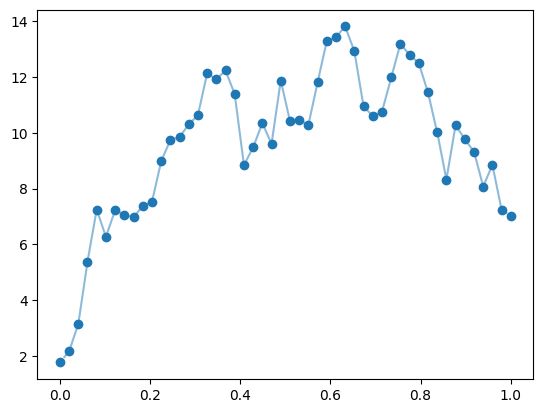

In [95]:
dom = np.linspace(0.01, 0.99, 1000)
plt.scatter(grid.x_grid, grid.y_obs)
plt.plot(dom, grid.linear_interpolation(dom), alpha=0.5)
#plt.scatter(rand_x, np.ones_like(rand_x))
plt.show()

# For building the regridding matrix

In [96]:
from scipy.sparse import lil_matrix

In [119]:
class Nonuniform2Uniform1DGrid:
    """Represents a uniform 1D grid.
    """

    def __init__(self, interval, n_points, x_obs):
        self.interval = interval
        self.a, self.b = interval
        self.n_points = n_points
        self.x_grid = np.linspace(self.a, self.b, self.n_points)
        self.h = self.x_grid[1] - self.x_grid[0]
        self.x_obs = x_obs

        # Get coefficients for linear interpolation
        self.left_idxs = self.nearest_grid_idx(x_obs)
        left_grid_points = self.x_grid[self.left_idxs]
        self.linear_interp_coeffs = ((x_obs-left_grid_points)/self.h)
     
    def nearest_grid_idx(self, x):
        """Given an array of x-coordinates, returns the index of the nearest x-cordinate 
        (from the left) on the grid.
        """
        assert np.all(np.diff(x) >= 0), "Array must be ordered in increasing order."
        assert np.amin(x) > self.a, "query points must be in between interval endpoints."
        assert np.amax(x) < self.b, "query points must be in between interval endpoints."

        indices = np.searchsorted(self.x_grid, x, side='right') - 1
        
        return indices
    

    def linear_interpolation(self, x):

        idxs = self.nearest_grid_idx(x)
        left_grid_points = self.x_grid[idxs]
        left_y_obs = self.y_obs[idxs]
        right_y_obs = self.y_obs[idxs + 1]
 
        return left_y_obs + ((x-left_grid_points)/self.h)*(right_y_obs - left_y_obs)


    def assemble_regridding_matrix(self):

        mat = lil_matrix((len(self.x_obs), len(self.x_grid)))

        # Fill matrix with coefficients
        for i in range(len(self.x_obs)):
            # Figure out column index
            j = self.left_idxs[i]

            # Get coeff
            c = self.linear_interp_coeffs[i]

            # Fill matrix
            mat[i,j] = (1-c)
            mat[i,j+1] = c

        return mat


    def matvec(self, y_obs):
        
        left_grid_points = self.x_grid[self.left_idxs]
        left_y_obs = y_obs[self.left_idxs]
        right_y_obs = y_obs[self.left_idxs + 1]
 
        return left_y_obs + ((self.x_obs-left_grid_points)/self.h)*(right_y_obs - left_y_obs)


    def rmatvec(self, y_obs):

        result = np.zeros_like(self.x_grid)

        left_idxs = np.searchsorted(self.x_grid, self.x_obs, side='right') - 1


        result += 


In [120]:
np.random.seed(0)
n_nonuniform = 15
lower = 0.01
upper = 0.98
x_nonuniform = np.linspace(lower,upper,n_nonuniform) +  0.01*np.random.normal(size=n_nonuniform)
x_nonuniform = np.clip(x_nonuniform, a_min=lower, a_max=upper)


In [121]:
grid = Nonuniform2Uniform1DGrid((0,1), 100, x_nonuniform)

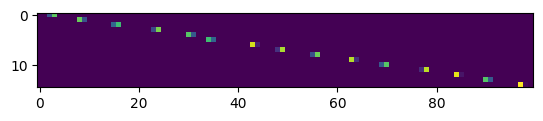

In [123]:
plt.imshow(grid.assemble_regridding_matrix().toarray())
plt.show()

In [124]:
mat = grid.assemble_regridding_matrix().toarray()

In [125]:
y_obs = np.cumsum(np.abs(np.random.normal(size=100)))

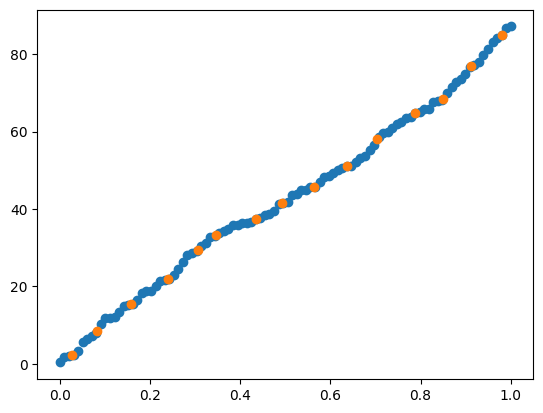

In [127]:
plt.scatter(grid.x_grid, y_obs)
plt.scatter(x_nonuniform, grid.matvec( y_obs ) )
plt.show()

In [128]:

def nearest_1d_grid_idx(x, grid, a=None, b=None):
    """Given an array of x-coordinates, returns the index of the nearest x-cordinate 
    (from the left) on the grid.
    """
    if a is None: a = np.amin(grid)
    if b is None: b = np.amax(grid)
    
    assert np.all(np.diff(x) >= 0), "Array must be ordered in increasing order."
    assert np.amin(x) > a, "query points must be in between interval endpoints."
    assert np.amax(x) < b, "query points must be in between interval endpoints."

    indices = np.searchsorted(grid, x, side='right') - 1
    
    return indices

In [133]:
class LinearNonuniform2Uniform1DGriddingOperator(jlinops._CustomLinearOperator):
    """Represents a linear operator mapping y-coordinates on a regular grid
    to y-coordinates on an irregular grid, using piecewise linear interpolation. 
    Used for the inverse interpolation problem.

    interval: a tuple [a,b] defining the uniform grid interval.
    n_points: the number of points on the uniform grid.
    x_nonuniform: the x-coordinates of the nonuniform grid.
    """
    
    def __init__(self, interval, n_points, x_nonuniform):

        self.interval = interval
        self.a, self.b = interval
        self.n_points = n_points
        self.x_uniform = np.linspace(self.a, self.b, self.n_points)
        self.h = self.x_uniform[1] - self.x_uniform[0]
        self.x_nonuniform = x_nonuniform

        # Get coefficients for linear interpolation
        self.left_idxs = nearest_1d_grid_idx(self.x_nonuniform, self.x_uniform, a=self.a, b=self.b)
        left_uniform_grid_points = self.x_uniform[self.left_idxs]
        self.linear_interp_coeffs = ((self.x_nonuniform-left_uniform_grid_points)/self.h)

        # Build regridding matrix
        shape = ( len(self.x_nonuniform), len(self.x_uniform) )
        regridding_mat = lil_matrix(shape)

        # Fill matrix with coefficients
        for i in range(len(self.x_nonuniform)):
            # Figure out column index
            j = self.left_idxs[i]

            # Get coeff
            c = self.linear_interp_coeffs[i]

            # Fill matrix
            regridding_mat[i,j] = (1-c)
            regridding_mat[i,j+1] = c

        self.regridding_mat = regridding_mat
        self.regridding_mat_t = self.regridding_mat.T
        
        def _matvec(v):
             return self.regridding_mat @ v

        def _rmatvec(v):
             return self.regridding_mat_t @ v
        
        super().__init__(shape, matvec=_matvec, rmatvec=_rmatvec, device="cpu")



In [134]:
np.random.seed(0)
n_nonuniform = 15
lower = 0.01
upper = 0.98
x_nonuniform = np.linspace(lower,upper,n_nonuniform) +  0.01*np.random.normal(size=n_nonuniform)
x_nonuniform = np.clip(x_nonuniform, a_min=lower, a_max=upper)

In [135]:
gridding_op = LinearNonuniform2Uniform1DGriddingOperator((0,1), 100, x_nonuniform)

In [143]:
y_uniform = np.cumsum(np.abs(np.random.normal(size=100)))

In [144]:
gridding_op.x_uniform.shape

(100,)

In [145]:
y_uniform.shape

(100,)

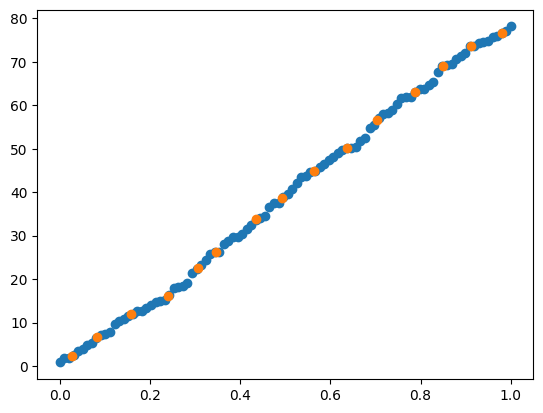

In [146]:
plt.scatter(gridding_op.x_uniform, y_uniform)
plt.scatter(gridding_op.x_nonuniform, gridding_op.matvec( y_uniform ) )
plt.show()